In [1]:
import json
import pandas as pd
import matplotlib
import os

In [2]:
def read_logs(fileName:str):
        log_path = os.path.join(os.path.abspath(''), "logs")
        with open(os.path.join(log_path, fileName), "r") as outfile:
                return json.load(outfile)

def create_aggregated_df(world_size: int):
        exp_df = []
        for rank in range(1, world_size + 1):
                if rank == 1:
                        rank_record = read_logs("rank_1.json")
                else:
                        rank_record = read_logs(f"rank_ddp_{rank}.json")
                exp_df.append(rank_record[0])
        return pd.DataFrame(exp_df)

exp_df = create_aggregated_df(7)
exp_df = exp_df.drop("epoch", axis=1)
exp_df

,experiment_key,training_loss,training_time,train_forward_pass,train_backward_pass,train_optimizer_step,train_post_processing,checkpointing,eval_validation_split_loss,eval_validation_split_perplexity,eval_time,eval_post_processing,eval_forward_pass,epoch_time,total_experiment_time
0,rank_1,3.168389,862.808604,221.466365,523.606467,8.335936,0.576413,15.872082,2.999401,20.073518,8.780048,0.004958,6.223922,887.460734,892.391252
1,rank_2,3.195714,435.509420,111.695451,264.768872,4.354529,0.344479,15.202761,3.018893,20.468898,4.846583,0.088729,3.486301,455.558764,466.253141
2,rank_3,3.206328,291.217091,75.170146,176.682444,2.963815,0.269703,15.255635,3.022949,20.552115,3.635025,0.024611,2.753952,310.107751,322.288305
3,rank_4,3.216707,219.509685,56.549870,132.850402,2.205632,0.198403,16.293393,3.029438,20.689044,2.959700,0.019406,2.293712,238.762777,252.186212
4,rank_5,3.226476,175.582499,46.933250,105.488938,1.563509,0.155181,15.675520,3.028158,20.664510,2.818983,0.075151,2.251828,194.077003,210.427583
5,rank_6,3.236998,146.725456,38.733284,88.320394,1.413714,0.143461,15.548673,3.029922,20.704916,2.650473,0.062674,2.180546,164.924602,182.985405
6,rank_7,3.246309,127.564351,34.483277,76.485691,1.123728,0.149506,15.634220,3.031667,20.734278,2.810978,0.072197,2.379818,146.009549,165.590063


In [12]:
exp_df.columns

Index(['experiment_key', 'training_loss', 'training_time',
       'train_forward_pass', 'train_backward_pass', 'train_optimizer_step',
       'train_post_processing', 'checkpointing', 'eval_validation_split_loss',
       'eval_validation_split_perplexity', 'eval_time', 'eval_post_processing',
       'eval_forward_pass', 'epoch_time', 'total_experiment_time'],
      dtype='object')

In [4]:
df_total_experiment_time = exp_df[['experiment_key', 'total_experiment_time']].groupby(by="experiment_key").max()
df_total_experiment_time.head()

,total_experiment_time
experiment_key,
rank_1,892.391252
rank_2,466.253141
rank_3,322.288305
rank_4,252.186212
rank_5,210.427583


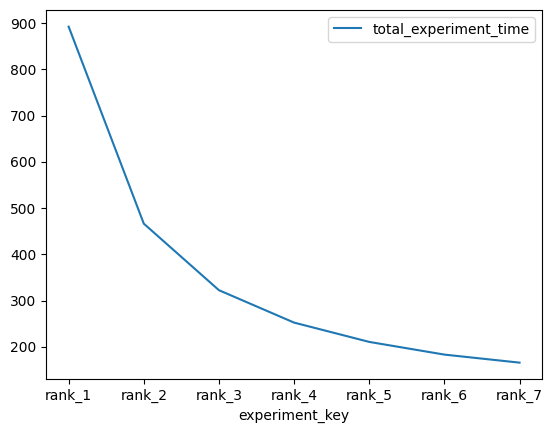

In [5]:
ax = df_total_experiment_time[['total_experiment_time']].plot()

In [6]:
exp_df.columns

Index(['experiment_key', 'training_loss', 'training_time',
       'train_forward_pass', 'train_backward_pass', 'train_optimizer_step',
       'train_post_processing', 'checkpointing', 'eval_validation_split_loss',
       'eval_validation_split_perplexity', 'eval_time', 'eval_post_processing',
       'eval_forward_pass', 'epoch_time', 'total_experiment_time'],
      dtype='object')

In [28]:
sum_keys_dict = {
    "experiment_key": ["experiment_key"],
    "checkpointing": ["checkpointing"],
    "steps": ['train_backward_pass', 'train_forward_pass', 'train_optimizer_step'],
    "steps+pp": ['train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'train_post_processing'],
    "steps+pp+eval": ['eval_forward_pass', 'train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'train_post_processing', 'eval_post_processing'],
    "steps+pp+eval+cp": ['eval_forward_pass', 'train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'eval_post_processing', 'train_post_processing', 'checkpointing'],
    "epochs": ['epoch_time'],
    "total": ["total_experiment_time"]
}

def create_sumfitted_df(df, key_dict):
        sumfitted_df = []
        for i in range(len(df)):
            rank_df = {}
            for col, sum_col in key_dict.items():
                if col == "experiment_key":
                    rank_df[col] = df.loc[i, col]
                else:
                    sum_val = 0.0
                    for col_s in sum_col: sum_val += df.loc[i, col_s]
                    rank_df[col] = sum_val
            sumfitted_df.append(rank_df)
        return pd.DataFrame(sumfitted_df)

df_durations = create_sumfitted_df(exp_df, sum_keys_dict)
df_durations

,experiment_key,checkpointing,steps,steps+pp,steps+pp+eval,steps+pp+eval+cp,epochs,total
0,rank_1,15.872082,753.408768,753.985181,760.214061,776.086144,887.460734,892.391252
1,rank_2,15.202761,380.818852,381.163332,384.738361,399.941122,455.558764,466.253141
2,rank_3,15.255635,254.816405,255.086108,257.864671,273.120306,310.107751,322.288305
3,rank_4,16.293393,191.605905,191.804307,194.117426,210.410818,238.762777,252.186212
4,rank_5,15.675520,153.985697,154.140878,156.467857,172.143377,194.077003,210.427583
5,rank_6,15.548673,128.467392,128.610853,130.854073,146.402746,164.924602,182.985405
6,rank_7,15.634220,112.092696,112.242202,114.694216,130.328436,146.009549,165.590063


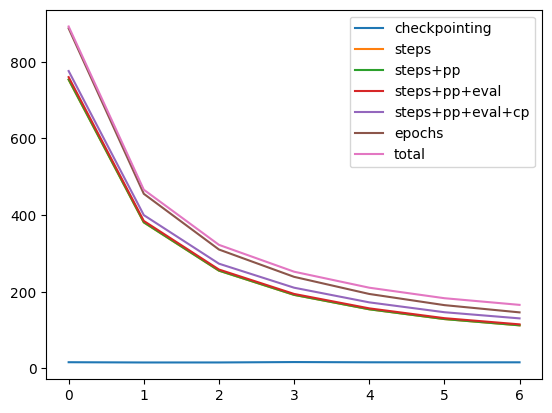

In [40]:
ax = df_durations.plot()

In [31]:
sum_keys_dict_2 = {
    "experiment_key": ["experiment_key"],
    "eval_forward_pass": ["eval_forward_pass"],
    "train_backward_pass": ["train_backward_pass"],
    "train_forward_pass": ["train_forward_pass"],
    "train_optimizer_step": ["train_optimizer_step"],
    "checkpointing": ["checkpointing"],
    "eval_post_processing": ["eval_post_processing"],
    "epochs": ['epoch_time'],
    "total": ["total_experiment_time"]
}

df_durations_2 = create_sumfitted_df(exp_df, sum_keys_dict_2)
df_durations_2

,experiment_key,eval_forward_pass,train_backward_pass,train_forward_pass,train_optimizer_step,checkpointing,eval_post_processing,epochs,total
0,rank_1,6.223922,523.606467,221.466365,8.335936,15.872082,0.004958,887.460734,892.391252
1,rank_2,3.486301,264.768872,111.695451,4.354529,15.202761,0.088729,455.558764,466.253141
2,rank_3,2.753952,176.682444,75.170146,2.963815,15.255635,0.024611,310.107751,322.288305
3,rank_4,2.293712,132.850402,56.549870,2.205632,16.293393,0.019406,238.762777,252.186212
4,rank_5,2.251828,105.488938,46.933250,1.563509,15.675520,0.075151,194.077003,210.427583
5,rank_6,2.180546,88.320394,38.733284,1.413714,15.548673,0.062674,164.924602,182.985405
6,rank_7,2.379818,76.485691,34.483277,1.123728,15.634220,0.072197,146.009549,165.590063


<Axes: >

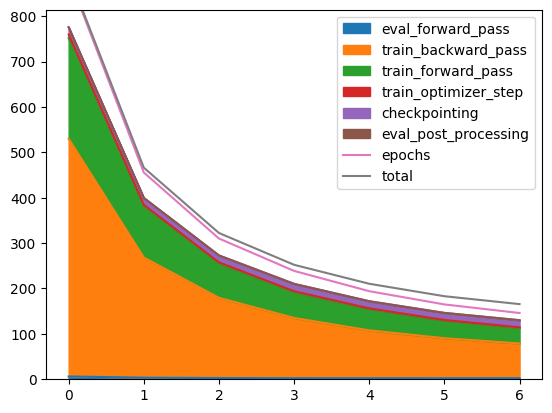

In [38]:
ax = df_durations_2[["eval_forward_pass", "train_backward_pass", "train_forward_pass", "train_optimizer_step", "checkpointing", "eval_post_processing"]].plot.area()
df_durations_2[["epochs", "total"]].plot(ax=ax)